In [1]:
%load_ext autoreload
%autoreload 2

import torch 
import pyro
import inspect

c:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from PFNExperiments.LinearRegression.GenerativeModels.GenerateData import GenerateData, check_data, check_and_plot_data
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataLM_Examples import make_lm_program_plain, make_lm_program_gamma_gamma, make_lm_program_gamma_gamma_augmented
from PFNExperiments.LinearRegression.GenerativeModels.LM_abstract import return_only_y, print_code

        def multivariate_lm_return_dict(x: torch.tensor, y: torch.tensor = None) -> dict:
            
            beta_dist = pyro.distributions.Gamma(a0, b0)
            beta_var = pyro.sample("beta_var", beta_dist)
        
            sigma_squared_dist = pyro.distributions.Gamma(a1, b1)
            sigma_squared = pyro.sample("sigma_squared", sigma_squared_dist)

            beta_cov = torch.eye(x.shape[1]) * beta_var # the covariance matrix of the parameters of the linear model
            beta = pyro.sample("beta", pyro.distributions.MultivariateNormal(torch.zeros(x.shape[1]), beta_cov)) # the parameters of the linear model

            mean = torch.matmul(x, beta)

            with pyro.plate("data", x.shape[0]):
                y = pyro.sample("obs", pyro.distributions.Normal(mean, sigma_squared), obs=y)

            return {
                        "x": x,
                        "y": y,
                        "sigma_squared": sigma_squared,
                        "beta_var

100%|██████████| 1000/1000 [00:01<00:00, 921.21it/s]


Discarded 0 samples
{'X': {'mean': tensor(0.5000), 'variance': tensor(0.0834), 'min': tensor(1.2517e-06), 'max': tensor(1.0000)}, 'y': {'mean': tensor(-0.0446), 'variance': tensor(9.6585), 'min': tensor(-21.7545), 'max': tensor(22.0839)}, 'beta': {'mean': tensor([-0.0697,  0.0009, -0.0148]), 'variance': tensor([2.6259, 2.4981, 2.6376]), 'min': tensor([-6.3639, -5.0796, -5.5191]), 'max': tensor([5.8799, 7.0646, 7.4698])}}
Statistics for sigma_squared:
Mean: 2.4371519088745117
Variance: 1.1893572807312012
Min: 0.3563418686389923
Max: 6.896963119506836


Statistics for beta_var:
Mean: 2.564728021621704
Variance: 1.2801399230957031
Min: 0.4852945804595947
Max: 7.302894592285156




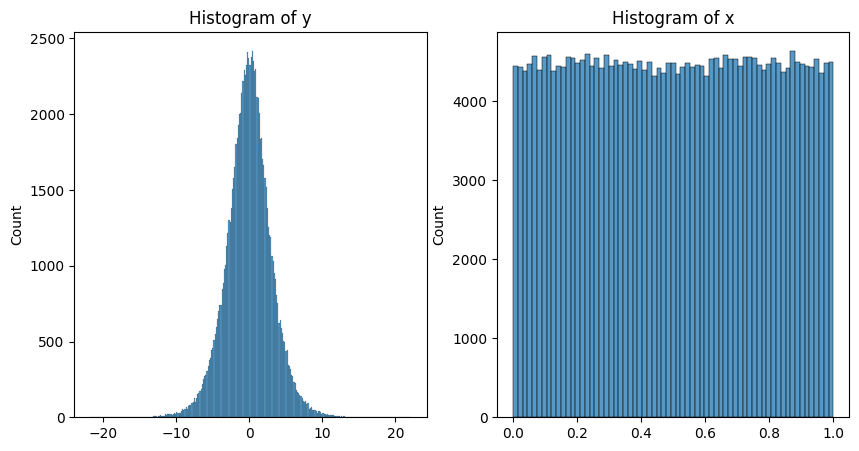

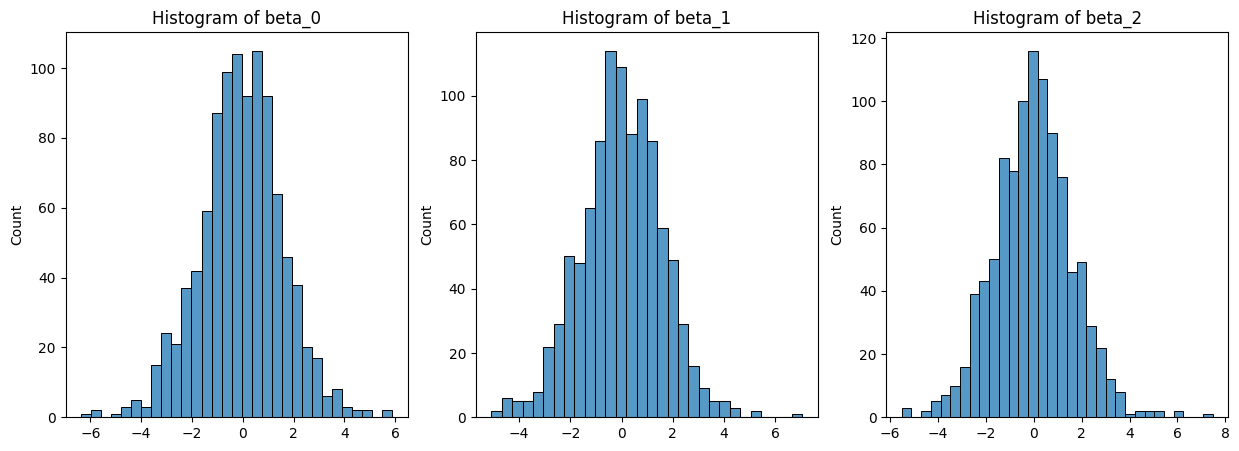

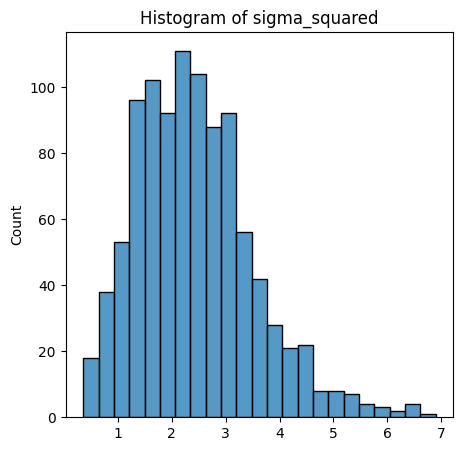

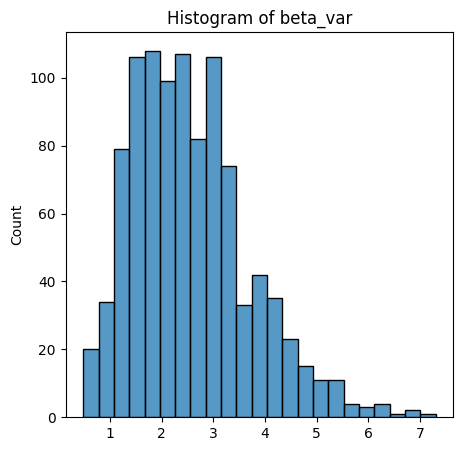

In [3]:
x_test = torch.rand(10, 5)
pprogram1 = make_lm_program_gamma_gamma()
pprogram1_y = return_only_y(pprogram1)
pprogram1
print_code(pprogram1)
generator = GenerateData(pprogram1)
generator.render_model()
_ = generator.check_model()


In [4]:
loader = generator.make_dataloaders_dynamic(
    n_batch=1000,
    
)

In [5]:
train_loader, val_loader, test_loader = loader

In [6]:
from PFNExperiments.LinearRegression.Models.Transformer import Transformer

In [7]:
batch = next(iter(train_loader))
x = batch['x']
y = batch['y']
beta = batch['beta']

In [8]:
print(x.shape)

torch.Size([256, 100, 5])


In [9]:
X_y = torch.cat([x, y.unsqueeze(-1)], dim = -1)

In [10]:
X_y = torch.cat([x, y.unsqueeze(-1)], dim = -1)

In [11]:
batch = next(iter(train_loader))
x = batch['x']
y = batch['y']
beta = batch['beta']
print(x.shape)
X_y = torch.cat([x, y.unsqueeze(-1)], dim = -1)

torch.Size([256, 100, 5])


In [12]:
def batch_to_model(batch:dict) -> torch.tensor:
    x = batch['x']
    y = batch['y']
    X_y = torch.cat([x, y.unsqueeze(-1)], dim = -1)
    return X_y

In [13]:
model = Transformer(
    n_features=6,
    seq_len=100,
    d_model=126,
    n_heads=2,
    dim_feedforward=126,
    n_layers=4,
    n_output_units_per_head=[5, 5*5, 5]
)

In [14]:
out = model(X_y)

In [15]:
mu, cov_factor, cov_diag = out

In [16]:
from PFNExperiments.Training.Trainer import Trainer, batch_to_model_lm, visualize_training_results
from PFNExperiments.Training.Losses import MSELoss_unsqueezed

from PFNExperiments.Training.EvalMetrics import mean_squared_error_torch_avg, mae_torch_avg, r2_score_torch_avg

In [17]:
from PFNExperiments.LinearRegression.Models.ModelPosterior import ModelPosteriorFullGaussian

In [18]:
nll_loss = ModelPosteriorFullGaussian(cov_reg_factor = 1e-6).negative_log_likelihood
nll_loss_avg = ModelPosteriorFullGaussian(cov_reg_factor = 1e-6).negative_log_likelihood_avg

In [19]:
lr = 1e-3
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)

In [20]:
additional_evals = {
    "loss": nll_loss_avg,
}
trainer = Trainer(
    model = model,
    optimizer=opt,
    scheduler = None,
    loss_function=nll_loss,
    trainset = train_loader,
    valset=val_loader,
    evaluation_functions= additional_evals,
    n_epochs = 10,
    early_stopping_patience = 20  
)

In [21]:
trainer.validate()

{'loss': tensor(2443.8252)}

In [22]:
r = trainer.train()

100%|██████████| 3/3 [00:07<00:00,  2.34s/it]


Epoch 0:
Training: {'loss': tensor(20.5800)}
Validation: {'loss': tensor(342.9576)}
Time: 7.500860691070557


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 3/3 [00:06<00:00,  2.10s/it]


Epoch 1:
Training: {'loss': tensor(18.3943)}
Validation: {'loss': tensor(193.5100)}
Time: 6.761072158813477


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 3/3 [00:06<00:00,  2.11s/it]


Epoch 2:
Training: {'loss': tensor(17.8639)}
Validation: {'loss': tensor(89.9411)}
Time: 6.77797794342041


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 3/3 [00:06<00:00,  2.07s/it]


Epoch 3:
Training: {'loss': tensor(14.2258)}
Validation: {'loss': tensor(107.1192)}
Time: 6.672585725784302


----------------------------------------------------------------------------------------------------


100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


Epoch 4:
Training: {'loss': tensor(13.9715)}
Validation: {'loss': tensor(72.4438)}
Time: 6.707016229629517


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 3/3 [00:06<00:00,  2.05s/it]


Epoch 5:
Training: {'loss': tensor(14.2178)}
Validation: {'loss': tensor(22.8516)}
Time: 6.699663400650024


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 3/3 [00:06<00:00,  2.15s/it]


Epoch 6:
Training: {'loss': tensor(12.2251)}
Validation: {'loss': tensor(16.2249)}
Time: 6.8967835903167725


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


Epoch 7:
Training: {'loss': tensor(13.2154)}
Validation: {'loss': tensor(15.0089)}
Time: 6.667357921600342


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 3/3 [00:06<00:00,  2.10s/it]


Epoch 8:
Training: {'loss': tensor(13.1814)}
Validation: {'loss': tensor(26.1874)}
Time: 6.872276782989502


----------------------------------------------------------------------------------------------------


100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Epoch 9:
Training: {'loss': tensor(12.2810)}
Validation: {'loss': tensor(19.6797)}
Time: 6.5927910804748535


----------------------------------------------------------------------------------------------------


In [23]:
model = trainer.model
model.eval()

Transformer(
  (mlp1): PositionwiseFeedForward(
    (w_1): Linear(in_features=6, out_features=66, bias=True)
    (w_2): Linear(in_features=66, out_features=126, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (act1): LeakyReLU(negative_slope=0.01)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=126, out_features=126, bias=True)
    )
    (linear1): Linear(in_features=126, out_features=126, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=126, out_features=126, bias=True)
    (norm1): LayerNorm((126,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((126,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
  

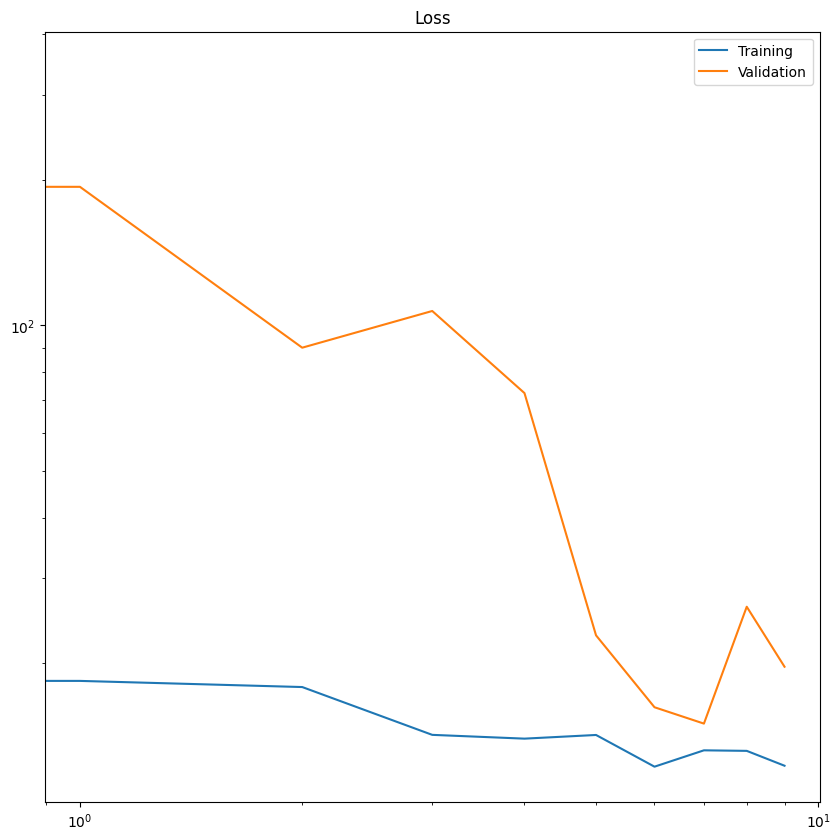

In [32]:
visualize_training_results(r, loglog=False)

In [33]:
from PFNExperiments.LinearRegression.Models.ModelToPosterior import ModelToPosterior
from PFNExperiments.LinearRegression.ComparisonModels.Hamiltionion_MC import Hamiltionian_MC

In [34]:
full_model = ModelToPosterior(model, ModelPosteriorFullGaussian(cov_reg_factor = 1e-6))

In [35]:
test_batch = next(iter(test_loader))
X_test = test_batch['x'][0]
y_test = test_batch['y'][0]

In [36]:
from PFNExperiments.Evaluation.ComparePosteriorSamples import compare_all_metrics, marginal_plots_hist_parallel, marginal_plots_kde_together, sample_plot_2d, plot

In [37]:
from PFNExperiments.LinearRegression.Evaluation.CompareModels import ModelComparison

In [38]:
hmc_sampler = Hamiltionian_MC(pprogram = pprogram1, n_warmup=500, n_samples=500, kernel_kwargs = {"step_size": 1e-3, "adapt_step_size": True})

In [39]:
comparison_model = ModelComparison(
    modelposterior=full_model,
    comparison_model=hmc_sampler
)

In [40]:
test_batch = next(iter(test_loader))

In [41]:
test_batch["x"].shape

torch.Size([150, 100, 5])

Sample: 100%|██████████| 1000/1000 [01:51,  8.97it/s, step size=2.74e-01, acc. prob=0.937]


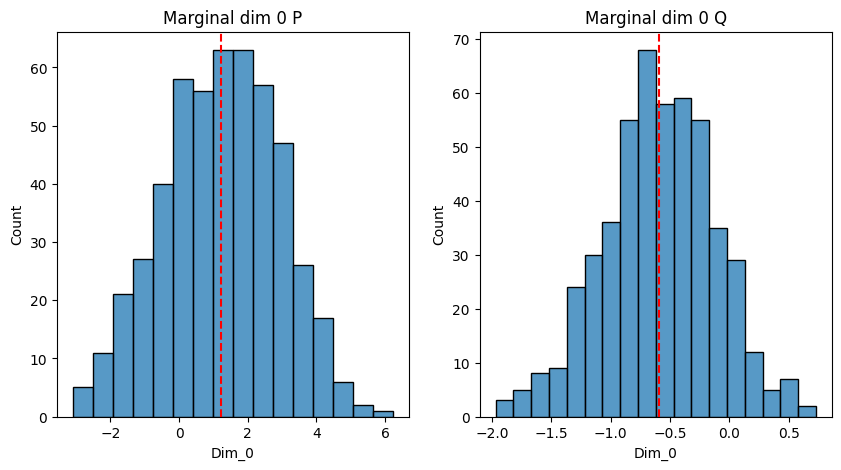

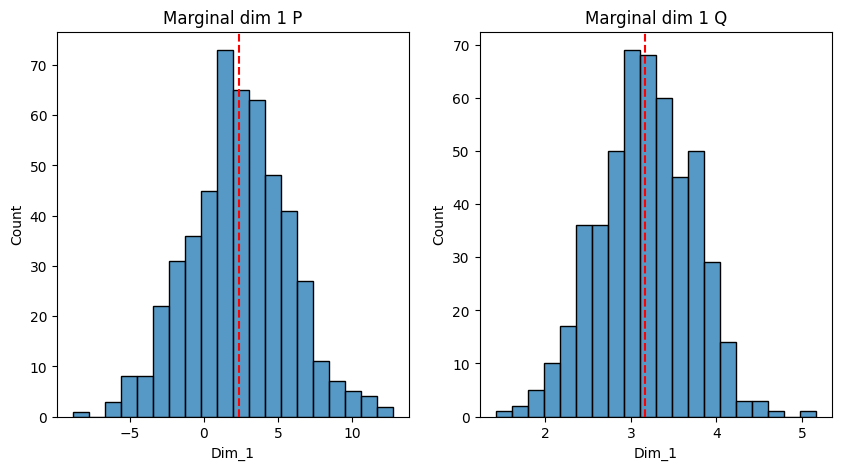

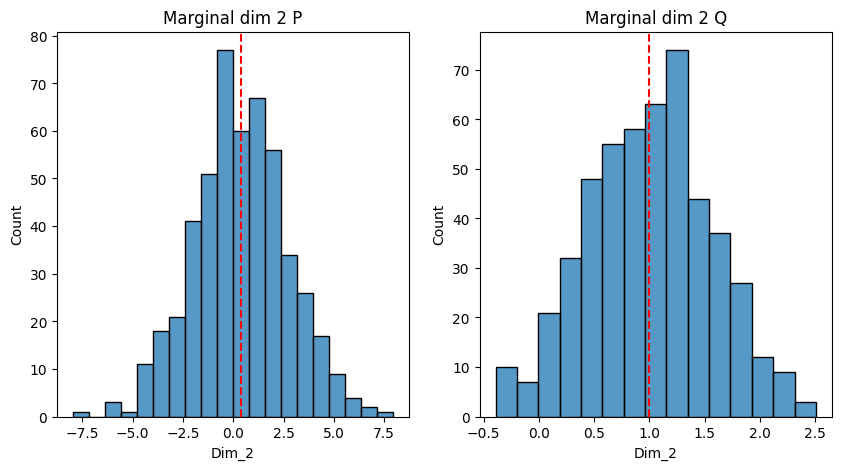

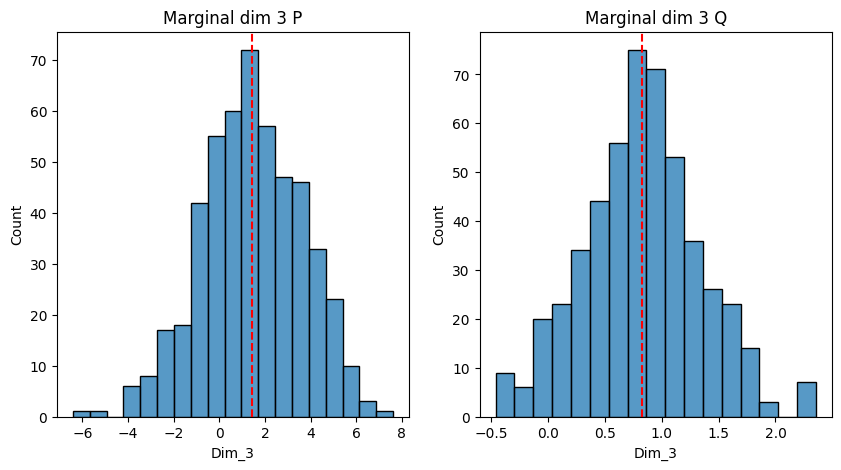

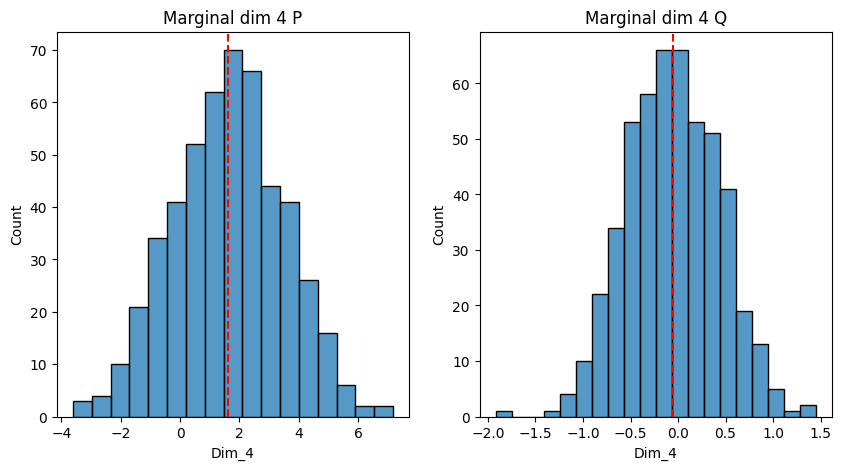

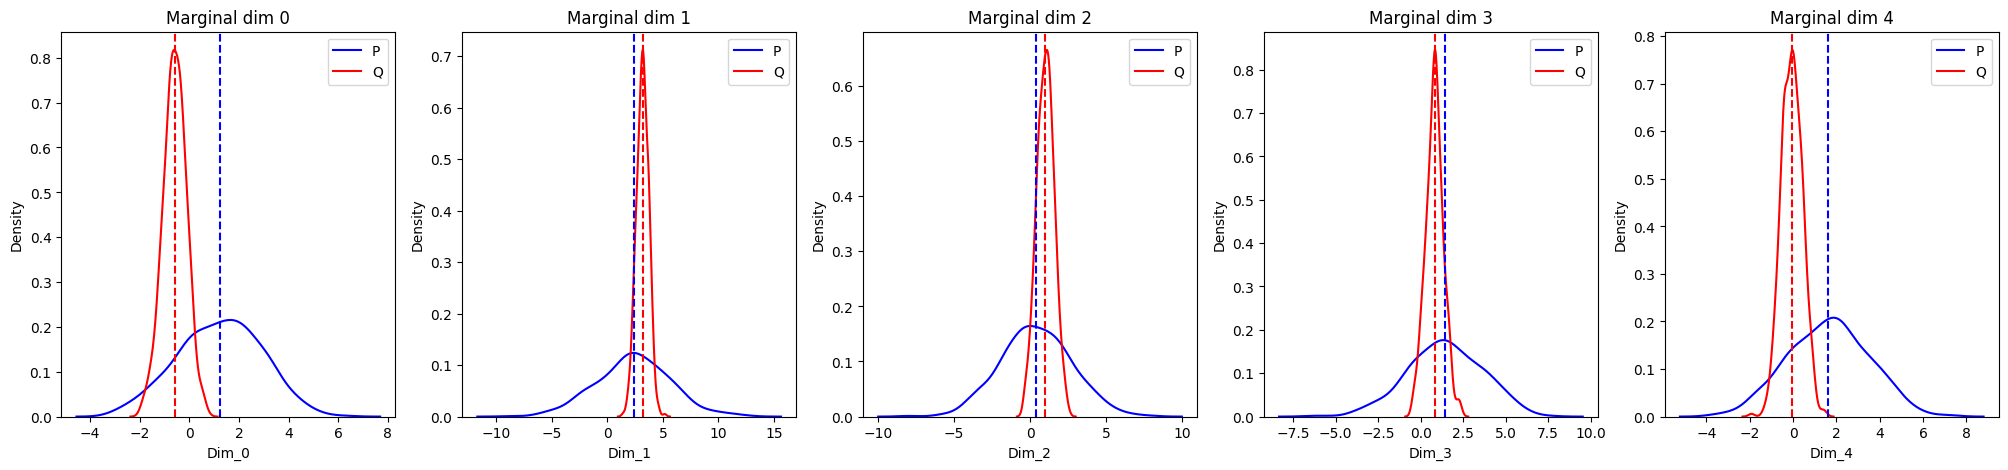

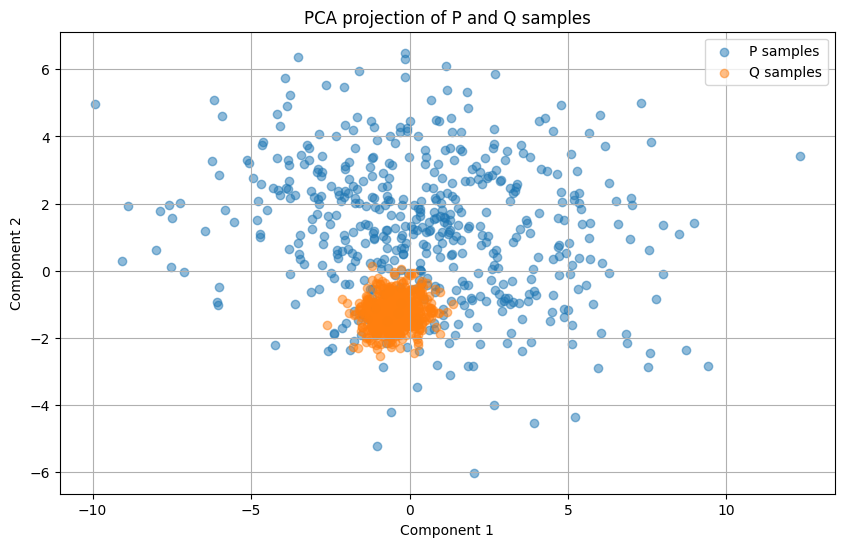

C:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\Evaluation\ComparePosteriorSamples.py:135: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3641.)
  (mu_Q - mu_P).T @ cov_Q_inv @ (mu_Q - mu_P) -
C:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\LinearRegression\Evaluation\CompareModels.py:187: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  batch_metrics_std[key1] = torch.std(torch.tensor([metric[key1] for metric in batch_metrics]))
C:\Users\arik_\Document

In [42]:
r = comparison_model.compare_sample_metrics_batch(test_batch["x"][:1], test_batch["y"][:1])

In [43]:
r[0]

[{'Wasserstein_distance with metric euclidean': 4.871082782745361,
  'KLD_Gaussian': 208.86582946777344,
  'mean_stats': {'absolute_mean_diff': tensor(1.1066),
   'squared_mean_diff': tensor(1.5089),
   'P_mean': tensor([1.2233, 2.3534, 0.3964, 1.4377, 1.6276]),
   'Q_mean': tensor([-0.5941,  3.1685,  1.0000,  0.8259, -0.0572])},
  'std_stats': {'absolute_std_diff': tensor(1.7735),
   'squared_std_diff': tensor(3.4487),
   'P_std': tensor([1.6865, 3.3486, 2.3325, 2.2113, 1.8647]),
   'Q_std': tensor([0.4699, 0.5506, 0.5599, 0.5142, 0.4816])},
  'q_025_stats': {'absolute_q_025_diff': tensor(2.9465),
   'squared_q_025_diff': tensor(13.2390),
   'P_q_025': tensor([-2.2454, -4.3391, -4.0799, -2.9792, -1.8232]),
   'Q_q_025': tensor([-1.5604,  2.1043, -0.1084, -0.2046, -0.9653])},
  'q_075_stats': {'absolute_q_075_diff': tensor(3.9216),
   'squared_q_075_diff': tensor(15.7635),
   'P_q_075': tensor([4.3532, 8.9744, 5.0542, 5.4159, 5.0523]),
   'Q_q_075': tensor([0.2906, 4.1661, 2.1015, 1.81

In [44]:
r[1]

{'Wasserstein_distance with metric euclidean': tensor(4.8711),
 'KLD_Gaussian': tensor(208.8658),
 'mean_stats': {'absolute_mean_diff': tensor(1.1066),
  'squared_mean_diff': tensor(1.5089),
  'P_mean': tensor(1.4077),
  'Q_mean': tensor(0.8686)},
 'std_stats': {'absolute_std_diff': tensor(1.7735),
  'squared_std_diff': tensor(3.4487),
  'P_std': tensor(2.2887),
  'Q_std': tensor(0.5152)},
 'q_025_stats': {'absolute_q_025_diff': tensor(2.9465),
  'squared_q_025_diff': tensor(13.2390),
  'P_q_025': tensor(-3.0934),
  'Q_q_025': tensor(-0.1469)},
 'q_075_stats': {'absolute_q_075_diff': tensor(3.9216),
  'squared_q_075_diff': tensor(15.7635),
  'P_q_075': tensor(5.7700),
  'Q_q_075': tensor(1.8484)},
 'iqr_stats': {'absolute_iqr_diff': tensor(2.4114),
  'squared_iqr_diff': tensor(6.2039),
  'P_iqr': tensor(3.1163),
  'Q_iqr': tensor(0.7049)},
 'cov_stats': {'absolute_cov_diff': tensor(1.4484),
  'squared_cov_diff': tensor(7.6499),
  'P_cov': tensor(1.2467),
  'Q_cov': tensor(0.0046)},
 'M

In [45]:
r[2]

{'Wasserstein_distance with metric euclidean': tensor(nan),
 'KLD_Gaussian': tensor(nan),
 'mean_stats': {'absolute_mean_diff': tensor(nan),
  'squared_mean_diff': tensor(nan),
  'P_mean': tensor(0.7072),
  'Q_mean': tensor(1.4409)},
 'std_stats': {'absolute_std_diff': tensor(nan),
  'squared_std_diff': tensor(nan),
  'P_std': tensor(0.6469),
  'Q_std': tensor(0.0401)},
 'q_025_stats': {'absolute_q_025_diff': tensor(nan),
  'squared_q_025_diff': tensor(nan),
  'P_q_025': tensor(1.1035),
  'Q_q_025': tensor(1.3911)},
 'q_075_stats': {'absolute_q_075_diff': tensor(nan),
  'squared_q_075_diff': tensor(nan),
  'P_q_075': tensor(1.8322),
  'Q_q_075': tensor(1.4860)},
 'iqr_stats': {'absolute_iqr_diff': tensor(nan),
  'squared_iqr_diff': tensor(nan),
  'P_iqr': tensor(0.7525),
  'Q_iqr': tensor(0.0783)},
 'cov_stats': {'absolute_cov_diff': tensor(nan),
  'squared_cov_diff': tensor(nan),
  'P_cov': tensor(2.6413),
  'Q_cov': tensor(0.1362)},
 'Marginal_dim_0': {'Wasserstein_distance with p = 

In [46]:
from PFNExperiments.LinearRegression.ComparisonModels.Variational_Inference import Variational_Inference, make_guide_program_gamma_gamma

In [47]:
guide_gamma_gamma = make_guide_program_gamma_gamma()

In [48]:
vi = Variational_Inference(
    pprogram=pprogram1,
    guide = guide_gamma_gamma,
    n_steps = 1000,
    n_samples=1000,
    lr = 1e-2
)

In [49]:
samples = vi.sample_posterior(X_test, y_test)

..........


In [50]:
comparison_model2 = ModelComparison(
    modelposterior=full_model,
    comparison_model=vi
)

..........


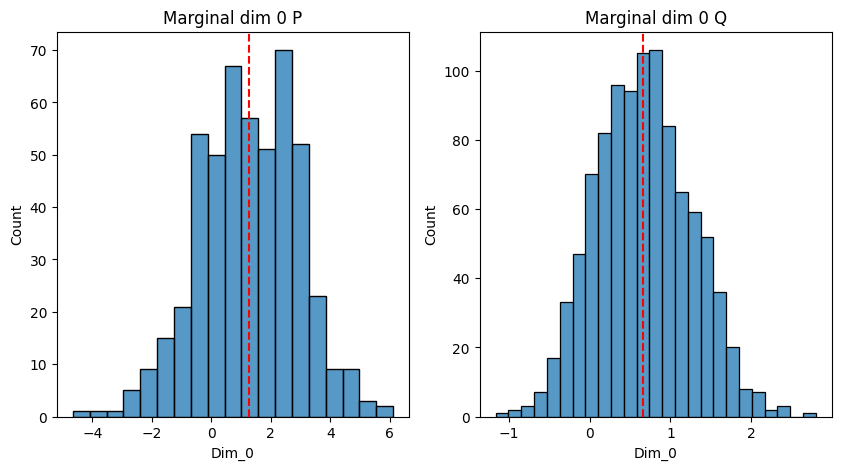

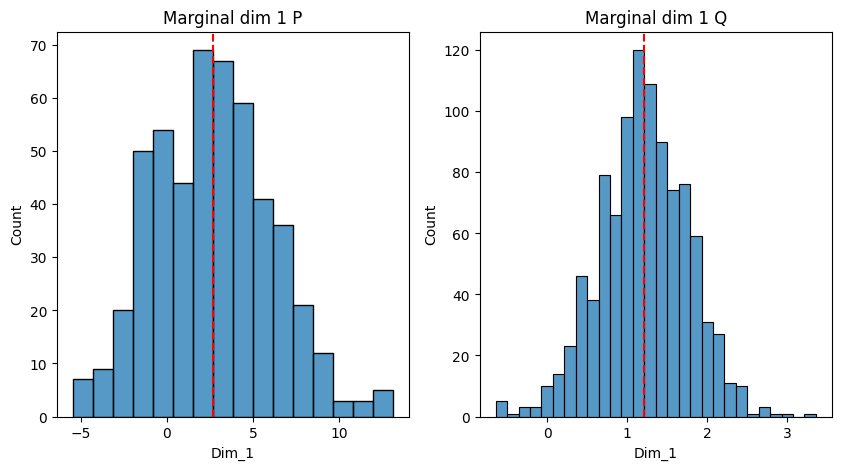

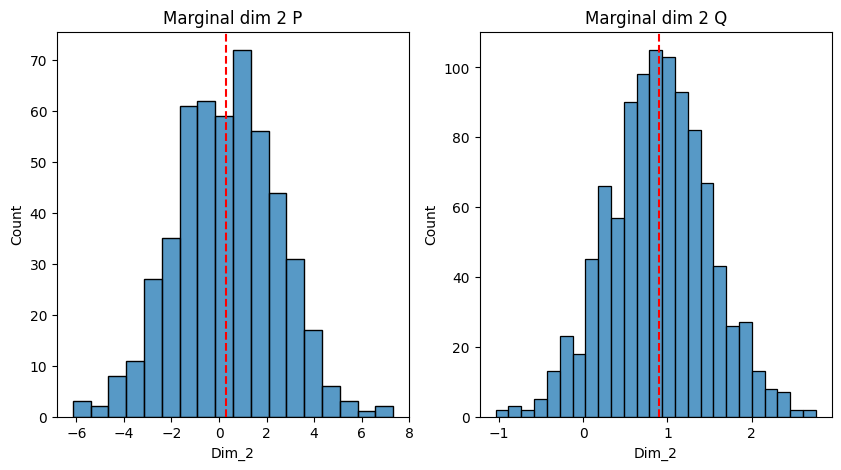

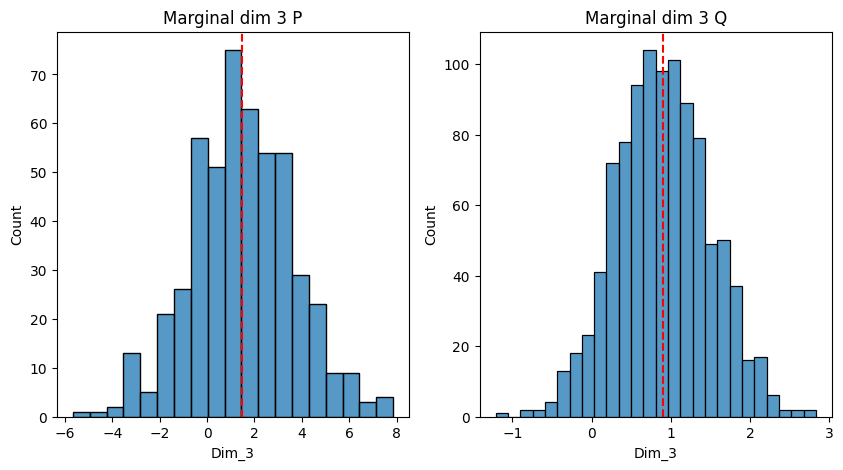

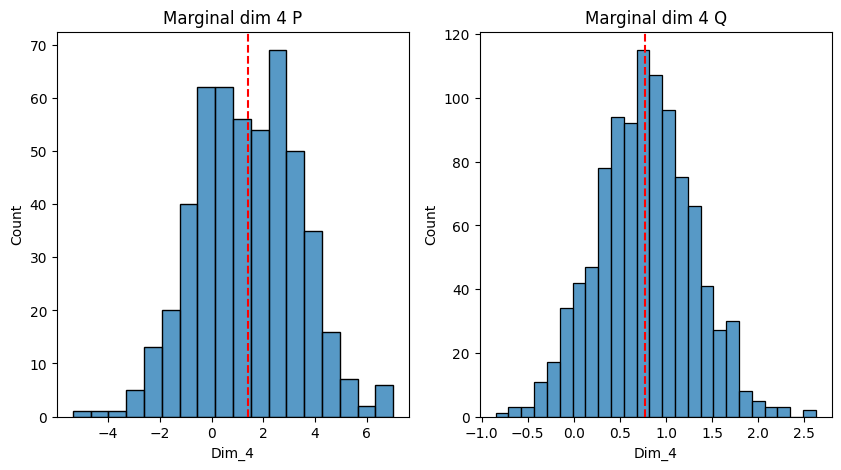

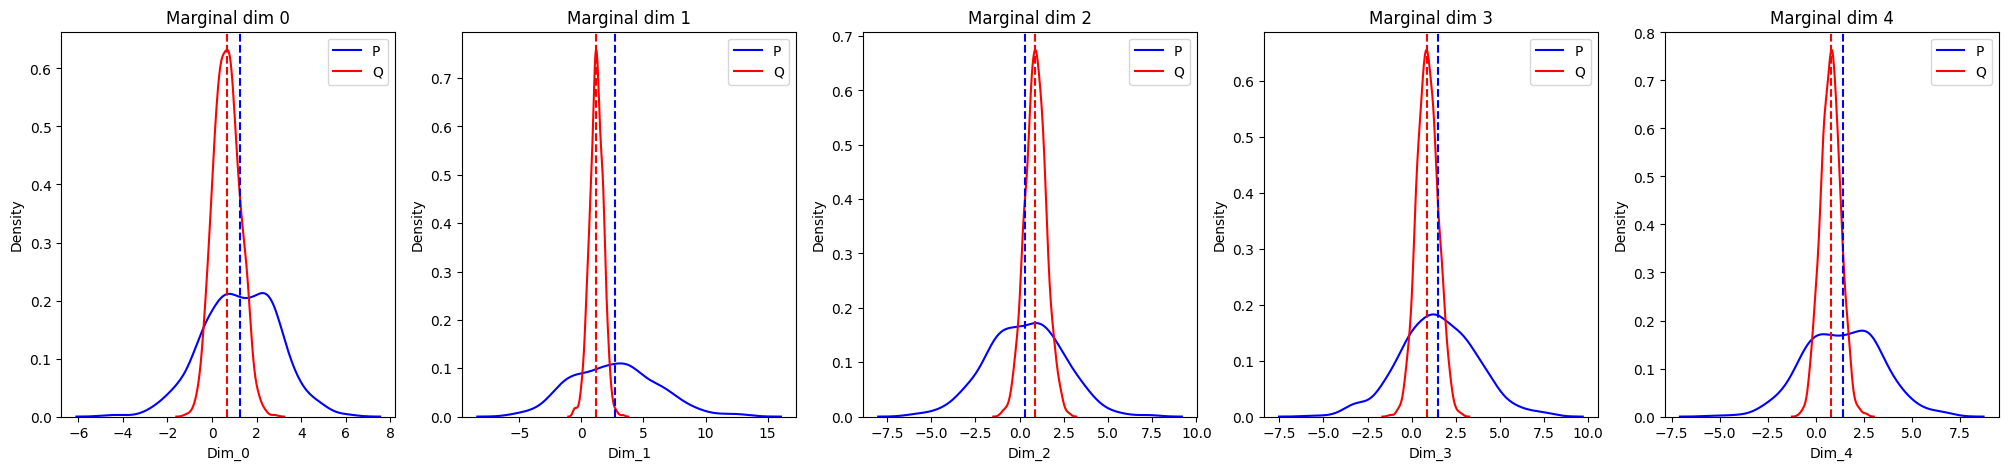

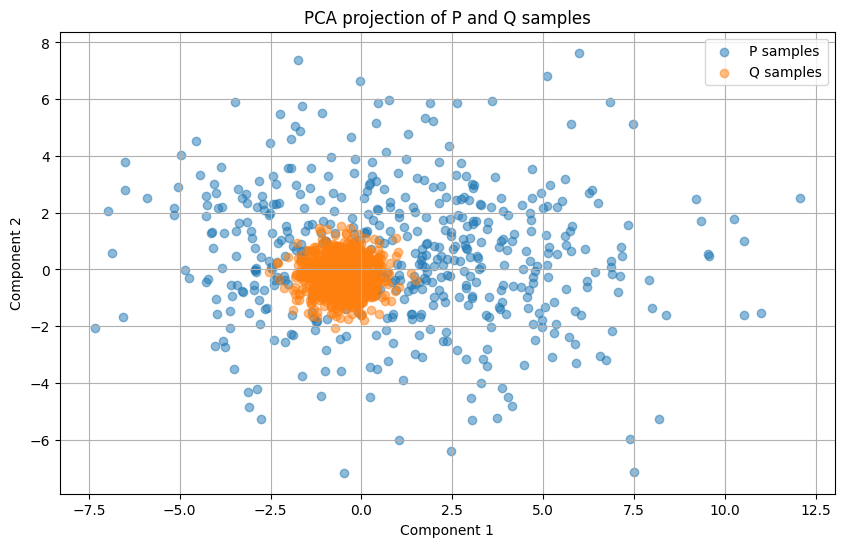

C:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\LinearRegression\Evaluation\CompareModels.py:187: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  batch_metrics_std[key1] = torch.std(torch.tensor([metric[key1] for metric in batch_metrics]))
C:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\LinearRegression\Evaluation\CompareModels.py:182: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  batch_metrics_std[key1][key2] = torch.std(torch.tensor([metric[key1][key2] for metric in batch_metrics]))
C:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\LinearRegression\Eva

([{'Wasserstein_distance with metric euclidean': 4.2043256759643555,
   'KLD_Gaussian': 40.1506233215332,
   'mean_stats': {'absolute_mean_diff': tensor(0.7724),
    'squared_mean_diff': tensor(0.7145),
    'P_mean': tensor([1.2738, 2.6697, 0.3109, 1.4855, 1.3972]),
    'Q_mean': tensor([0.6631, 1.2112, 0.8963, 0.9016, 0.7735])},
   'std_stats': {'absolute_std_diff': tensor(1.6944),
    'squared_std_diff': tensor(3.2360),
    'P_std': tensor([1.6542, 3.3998, 2.1367, 2.1522, 1.9717]),
    'Q_std': tensor([0.5869, 0.5512, 0.5941, 0.5904, 0.5197])},
   'q_025_stats': {'absolute_q_025_diff': tensor(2.7112),
    'squared_q_025_diff': tensor(7.9104),
    'P_q_025': tensor([-1.9933, -3.2687, -3.8390, -3.1133, -2.3653]),
    'Q_q_025': tensor([-0.4022,  0.1079, -0.2796, -0.2086, -0.2411])},
   'q_075_stats': {'absolute_q_075_diff': tensor(3.8789),
    'squared_q_075_diff': tensor(18.1190),
    'P_q_075': tensor([4.4858, 9.4295, 4.2915, 5.8190, 5.3315]),
    'Q_q_075': tensor([1.7957, 2.2304, 2

In [51]:
comparison_model2.compare_sample_metrics_batch(test_batch["x"][:1], test_batch["y"][:1])

In [52]:
from PFNExperiments.LinearRegression.Evaluation.CompareComparisonModels import CompareComparisonModels

In [53]:
comparison_model_comparer = CompareComparisonModels(
    comparison_model_1=vi,
    comparison_model_2=hmc_sampler,
    n_samples_comparison_model_1=1000,
    n_samples_comparison_model_2=500
)

..........


Sample: 100%|██████████| 1000/1000 [01:07, 14.85it/s, step size=2.57e-01, acc. prob=0.947]


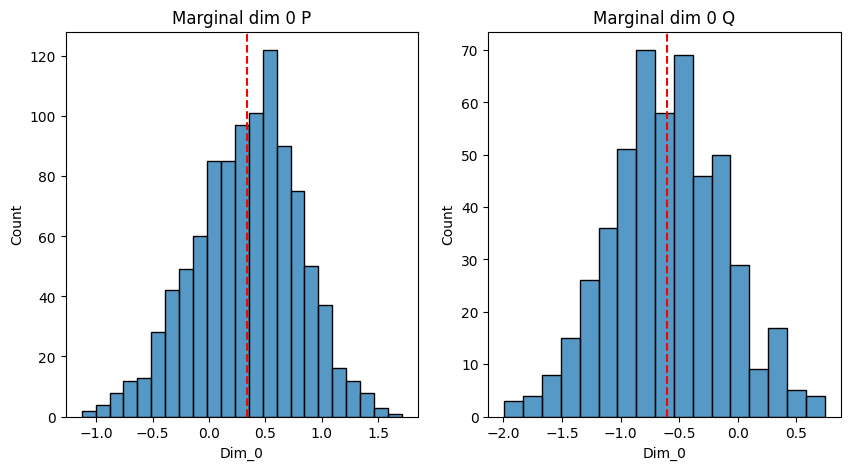

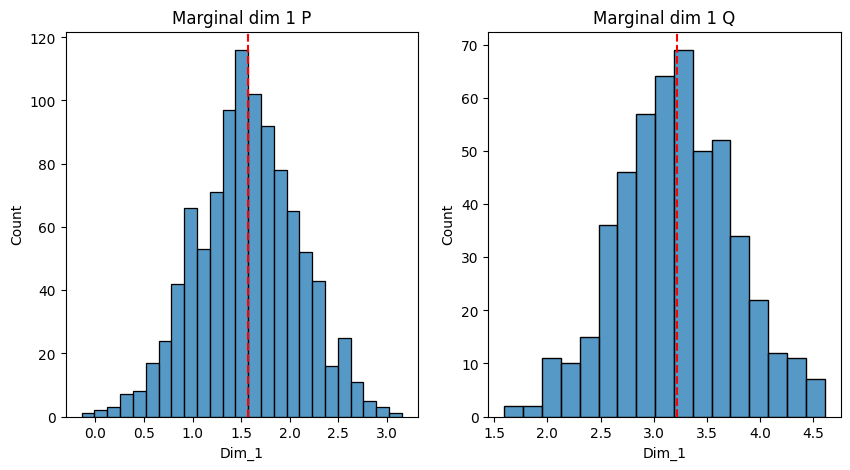

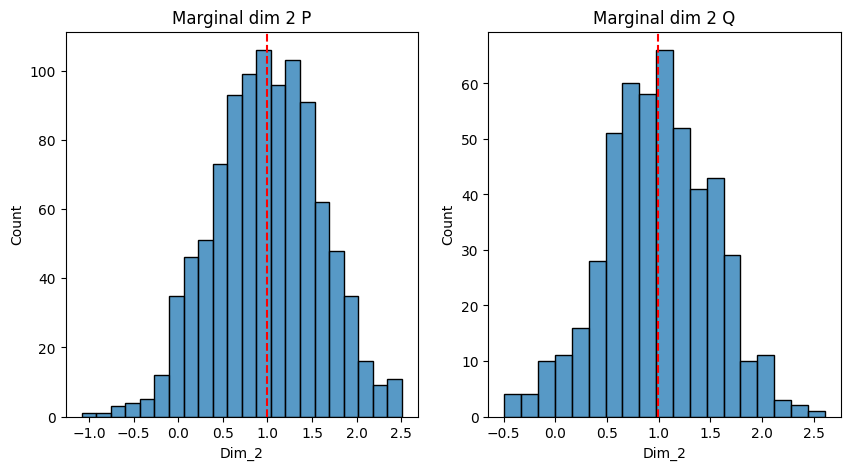

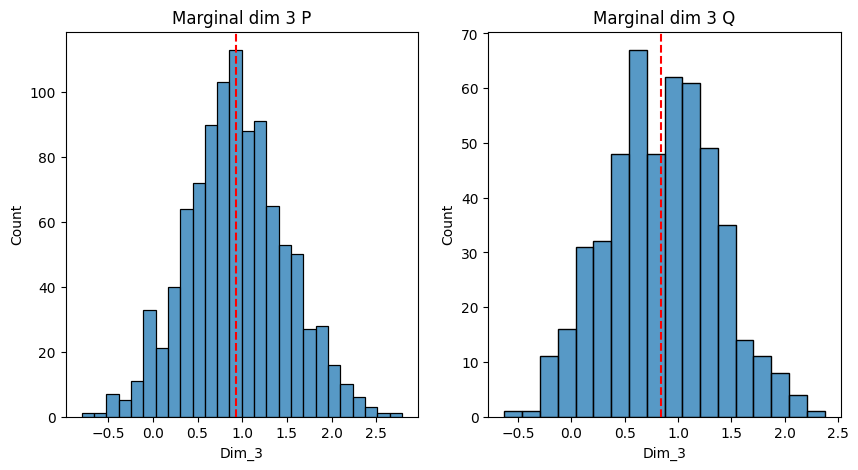

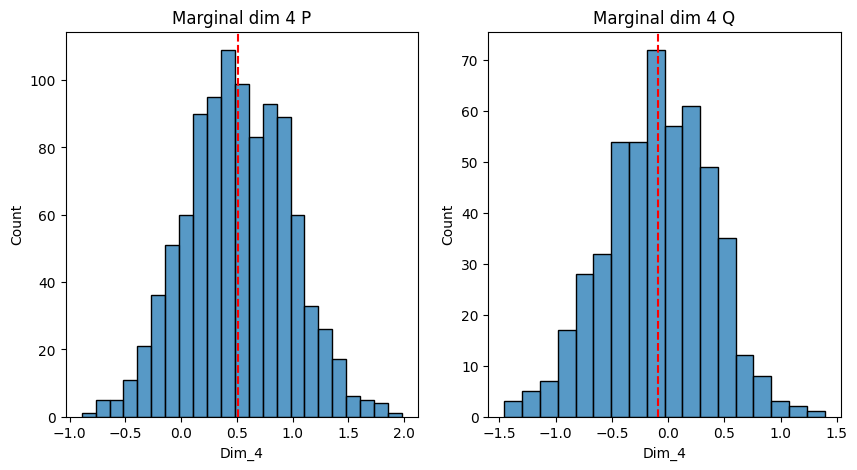

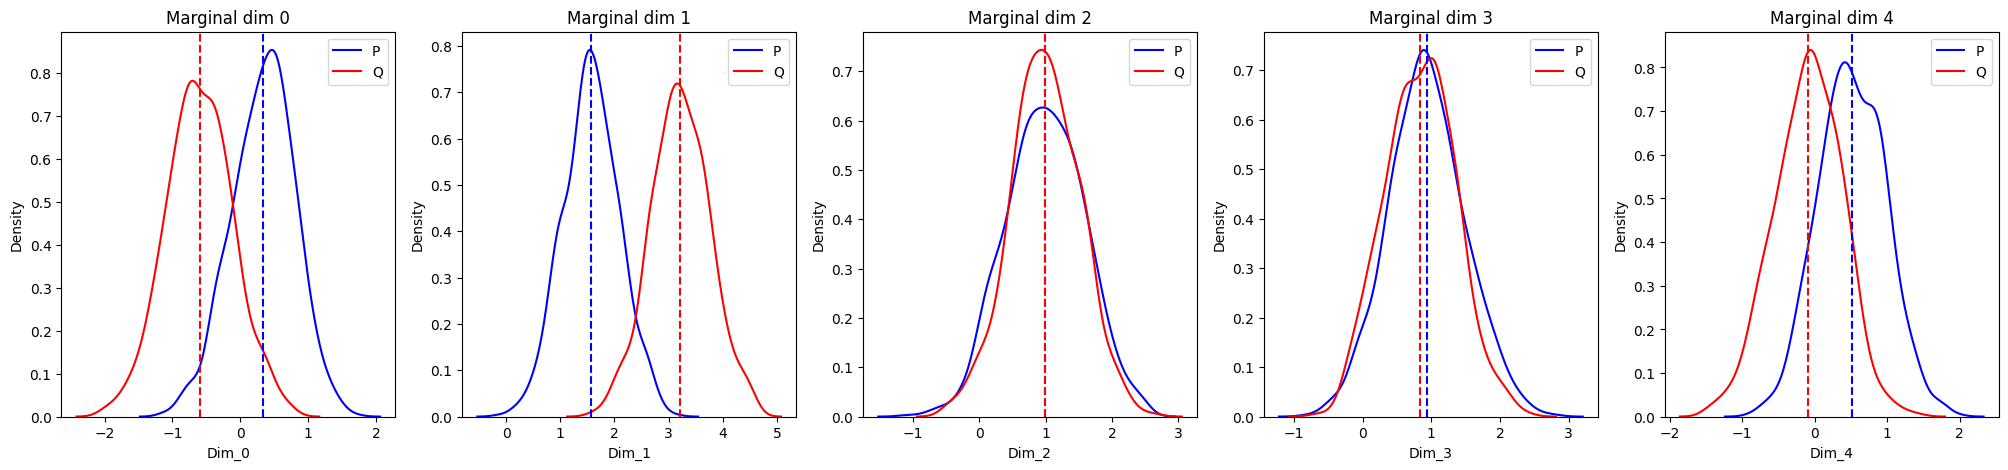

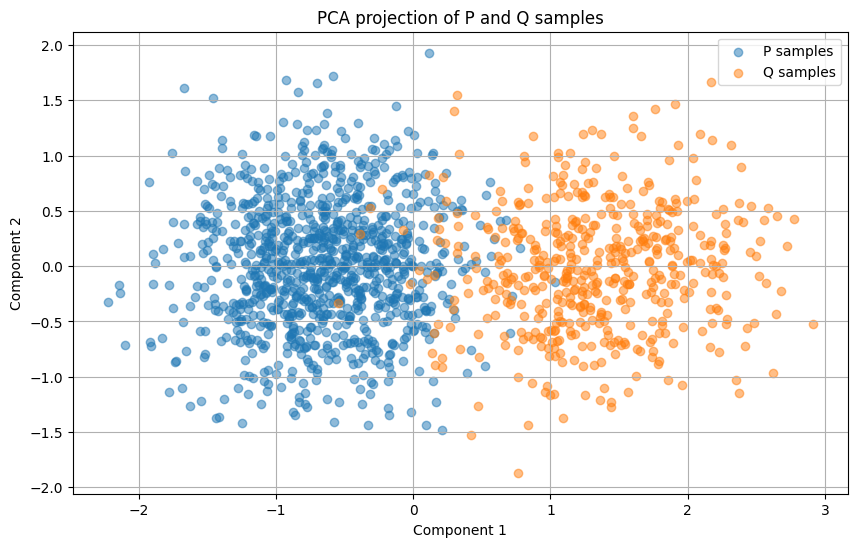

C:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\LinearRegression\Evaluation\CompareComparisonModels.py:144: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  batch_metrics_std[key1] = torch.std(torch.tensor([metric[key1] for metric in batch_metrics]))
C:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\LinearRegression\Evaluation\CompareComparisonModels.py:139: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  batch_metrics_std[key1][key2] = torch.std(torch.tensor([metric[key1][key2] for metric in batch_metrics]))
C:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\

([{'Wasserstein_distance with metric euclidean': 2.0463016033172607,
   'KLD_Gaussian': 8.957575798034668,
   'mean_stats': {'absolute_mean_diff': tensor(0.6564),
    'squared_mean_diff': tensor(0.7912),
    'P_mean': tensor([0.3374, 1.5705, 0.9917, 0.9355, 0.5134]),
    'Q_mean': tensor([-0.5994,  3.2151,  0.9938,  0.8412, -0.0907])},
   'std_stats': {'absolute_std_diff': tensor(0.0337),
    'squared_std_diff': tensor(0.0016),
    'P_std': tensor([0.4633, 0.5170, 0.5882, 0.5550, 0.4616]),
    'Q_std': tensor([0.4870, 0.5400, 0.5174, 0.5090, 0.4668])},
   'q_025_stats': {'absolute_q_025_diff': tensor(0.6447),
    'squared_q_025_diff': tensor(0.7380),
    'P_q_025': tensor([-0.6490,  0.5796, -0.1242, -0.1074, -0.3402]),
    'Q_q_025': tensor([-1.5721,  2.1166, -0.0628, -0.1226, -1.0266])},
   'q_075_stats': {'absolute_q_075_diff': tensor(0.6954),
    'squared_q_075_diff': tensor(0.8238),
    'P_q_075': tensor([1.1937, 2.6010, 2.1323, 2.0324, 1.4046]),
    'Q_q_075': tensor([0.3897, 4.34

In [54]:
comparison_model_comparer.compare_sample_metrics_batch(test_batch["x"][:1], test_batch["y"][:1])